In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from gammapy.irf import load_cta_irfs
from gammapy.maps import WcsGeom, MapAxis
from regions import CircleSkyRegion
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    GaussianSpatialModel,
    SkyModel,
    Models,
    PointSpatialModel,
    FoVBackgroundModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.makers import MapDatasetMaker, SafeMaskMaker, RingBackgroundMaker, FoVBackgroundMaker
from gammapy.modeling import Fit
from gammapy.maps import Map
from scipy.stats import norm
from gammapy.data import Observation
from gammapy.datasets import MapDataset, MapDatasetOnOff
from gammapy.estimators import ExcessMapEstimator, FluxPointsEstimator

In [3]:
import scipy.stats as stats
import math
import statistics
import os

In [4]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [5]:
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


In [6]:
# Define the observation parameters (typically the observation duration and the pointing position):
livetime = 1.0 * u.hr
l = 0.2
coord = SkyCoord(233.738, 23.503, unit="deg", frame="icrs")
pointing = coord.galactic

In [7]:
# Define map geometry for binned simulation
energy_reco = MapAxis.from_edges(
    np.logspace(-1.0, 1.0, 10), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(coord.galactic.l.deg, coord.galactic.b.deg),
    binsz=0.02,
    width=(3, 3),
    frame="galactic",
    axes=[energy_reco],
)
# It is usually useful to have a separate binning for the true energy axis
energy_true = MapAxis.from_edges(
    np.logspace(-1.5, 1.5, 30), unit="TeV", name="energy_true", interp="log"
)

empty = MapDataset.create(geom, name="dataset-simu")

In [8]:
# Define sky model to used simulate the data.
# Here we use a Point spatial model and a Exponential Cut Power Law spectral model.
spatial_model = PointSpatialModel(
    lon_0=coord.galactic.l, lat_0=coord.galactic.b, frame="galactic"
)
spectral_model = ExpCutoffPowerLawSpectralModel(
    index=2.351, amplitude="2.956e-14 cm-2 s-1 TeV-1", reference="1 TeV", lambda_=l * u.Unit("TeV-1"), alpha = 1
)
model_simu = SkyModel(
    spatial_model=spatial_model,
    spectral_model=spectral_model,
    name="model-simu",
)

bkg_model = FoVBackgroundModel(dataset_name="dataset-simu")

models = Models([model_simu, bkg_model])
print(models)

Models

Component 0: SkyModel

  Name                      : model-simu
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :   2.351              
    amplitude               :   2.96e-14  1 / (cm2 s TeV)
    reference    (frozen)   :   1.000  TeV         
    lambda_                 :   0.200  1 / TeV     
    alpha        (frozen)   :   1.000              
    lon_0                   :  36.627  deg         
    lat_0                   :  53.029  deg         

Component 1: FoVBackgroundModel

  Name                      : dataset-simu-bkg
  Datasets names            : ['dataset-simu']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                    :   1.000              
    tilt         (frozen)   :   0.000              
    reference    (frozen)   :   1.000  TeV         




In [9]:
spatial_model_1 = PointSpatialModel(
    lon_0=coord.galactic.l, lat_0=coord.galactic.b, frame="galactic"
)
spectral_model_1 = ExpCutoffPowerLawSpectralModel(
    index=2, amplitude="1e-13 cm-2 s-1 TeV-1", reference="1 TeV", lambda_=0 * u.Unit("TeV-1"), alpha = 1
)
model_simu_1 = SkyModel(
    spatial_model=spatial_model_1,
    spectral_model=spectral_model_1,
    name="model-simu",
)

bkg_model_1 = FoVBackgroundModel(dataset_name="dataset-simu")

models_1 = Models([model_simu_1, bkg_model_1])
print(models_1)

Models

Component 0: SkyModel

  Name                      : model-simu
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :   2.000              
    amplitude               :   1.00e-13  1 / (cm2 s TeV)
    reference    (frozen)   :   1.000  TeV         
    lambda_                 :   0.000  1 / TeV     
    alpha        (frozen)   :   1.000              
    lon_0                   :  36.627  deg         
    lat_0                   :  53.029  deg         

Component 1: FoVBackgroundModel

  Name                      : dataset-simu-bkg
  Datasets names            : ['dataset-simu']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                    :   1.000              
    tilt         (frozen)   :   0.000              
    reference    (frozen)   :   1.000  TeV         




In [10]:
def FoV(energy_reco, energy_true, livetime, irfs, pointing, geom, models, models_1):
    model = models.copy()
    model_1 = models_1.copy()
    obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
    maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])
    maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=3.5 * u.deg)
    dataset = maker.run(empty, obs)
    dataset = maker_safe_mask.run(dataset, obs)
    dataset.models = model
    dataset.fake(random_state=42)
    
    dataset1 = dataset.copy()
    dataset1.models = bkg_model
    
    dataset2 = dataset.copy()
    dataset2.models = bkg_model
    
    estimator = ExcessMapEstimator(0.04 * u.deg, selection_optional=[])
    lima_maps = estimator.run(dataset1)
    significance_map = lima_maps["sqrt_ts"]
    excess_map = lima_maps["excess"]
    
    geom_image = geom.to_image().to_cube([energy_reco.squash()])
    regions = CircleSkyRegion(center=pointing, radius=0.2 * u.deg)
    exclusion_mask = Map.from_geom(geom_image)
    exclusion_mask.data = geom_image.region_mask([regions], inside=False)
    maker_fov = FoVBackgroundMaker(method="fit", exclusion_mask=exclusion_mask)
    
    ## original code
    dataset1 = dataset1.to_spectrum_dataset(on_region=regions)
    dataset2 = dataset2.to_spectrum_dataset(on_region=regions)
    dataset1 = maker_fov.run(dataset1)
    dataset2 = maker_fov.run(dataset2)
    
    TS0 = dataset1.stat_sum()
    models_fit = model[0].copy()
    models_fit_1 = model[0].copy()
    dataset1.models = models_fit
    dataset2.models = models_fit_1
    
    dataset1.models.parameters['lambda_'].frozen = True
    fit = Fit([dataset1])
    result = fit.run()
    print(result)
    TS1 = result.total_stat
    del_TS = TS0 - TS1
    
    dataset2.models.parameters['lambda_'].frozen = False
    fit = Fit([dataset2])
    result = fit.run()
    print(result)
    TS2 = result.total_stat
    del_TS_1 = TS1 - TS2
    del_TS_2 = TS0 - TS2
    
    return del_TS, dataset2, models_fit_1, del_TS_1, del_TS_2, significance_map, excess_map, dataset1, models_fit

In [11]:
def excess_maps(significance_map, excess_map):
    plt.figure(figsize=(10, 10))
    ax1 = plt.subplot(221, projection=significance_map.geom.wcs)
    ax2 = plt.subplot(222, projection=excess_map.geom.wcs)
    
    ax1.set_title("Significance map")
    significance_map.plot(ax=ax1, add_cbar=True)

    ax2.set_title("Excess map")
    excess_map.plot(ax=ax2, add_cbar=True)
    return

In [12]:
x = [100.0,250.0,500.0,750.0,1000.0] * u.hr
y1 = []

In [13]:
for i in range(len(x)):
    y1.append(FoV(energy_reco, energy_true, x[i], irfs, pointing, geom, models, models_1))

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : False
	message    : Optimization failed.
	nfev       : 97
	total stat : -668563.29

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : False
	message    : Optimization failed. Estimated distance to minimum too large.
	nfev       : 464
	total stat : -668563.29

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : False
	message    : Optimization failed. Estimated distance to minimum too large.
	nfev       : 80
	total stat : -1849831.79

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : False
	message    : Optimization failed. Estimated distance to minimum too large.
	nfev       : 215
	total stat : -1849832.19

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : False
	message    : Optimization failed. Estimated distance to minimum too large.
	nfev       : 74
	total stat : -3954897.16

OptimizeResult

	backend    : minuit
	method     : 

In [14]:
del_TS_ = []
del_TS_1 = []
del_TS_2 = []
dataset_ = []
model_ = []
significance_ = []
excess_ = []
dataset_1 = []
model_1 = []
for i in range(len(x)):
    del_TS_.append(y1[i][0])
    dataset_.append(y1[i][1])
    model_.append(y1[i][2])
    del_TS_1.append(y1[i][3])
    del_TS_2.append(y1[i][4])
    significance_.append(y1[i][5])
    excess_.append(y1[i][6])
    dataset_1.append(y1[i][7])
    model_1.append(y1[i][8])

In [15]:
print(del_TS_[0:5])
print(del_TS_1[0:5])
print(del_TS_2[0:5])

[18.320905240252614, 26.71117848274298, 43.405473976396024, 78.78101962711662, 120.75454604439437]
[0.001875813934020698, 0.4045891824644059, -0.005990982986986637, 0.35115884337574244, 0.801904896274209]
[18.322781054186635, 27.115767665207386, 43.39948299340904, 79.13217847049236, 121.55645094066858]


Text(0.5, 1.0, 'Original code')

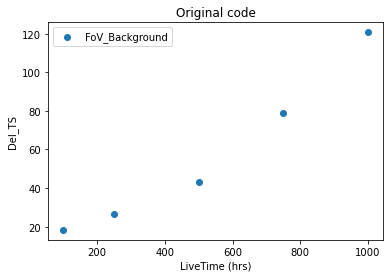

In [16]:
plt.scatter(x,del_TS_[0:5])
#plt.xscale("log")
plt.legend(["FoV_Background"])
plt.ylabel("Del_TS")
plt.xlabel("LiveTime (hrs)")
plt.title("Original code")

Text(0.5, 1.0, 'Original code')

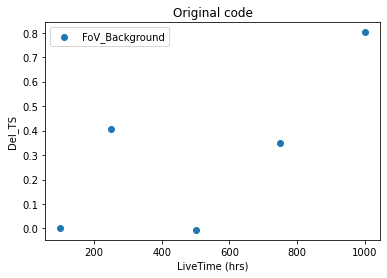

In [17]:
plt.scatter(x,del_TS_1[0:5])
#plt.xscale("log")
plt.legend(["FoV_Background"])
plt.ylabel("Del_TS")
plt.xlabel("LiveTime (hrs)")
plt.title("Original code")

Text(0.5, 1.0, 'Original code')

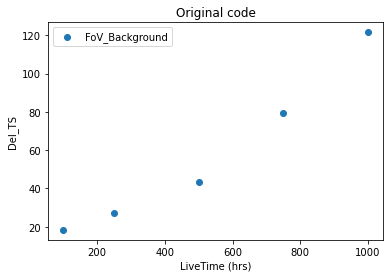

In [18]:
plt.scatter(x,del_TS_2[0:5])
#plt.xscale("log")
plt.legend(["FoV_Background"])
plt.ylabel("Del_TS")
plt.xlabel("LiveTime (hrs)")
plt.title("Original code")

In [19]:
def flux_plt(model, dataset):
    spec = model.spectral_model
    energy_edges = np.logspace(-1.0, 1.0, 5) * u.TeV
    fpe = FluxPointsEstimator(energy_edges=energy_edges)
    flux_points = fpe.run(datasets=[dataset])
    energy_range = [0.1, 10] * u.TeV
    spec.plot(energy_range=energy_range, energy_power=2)
    ax = spec.plot_error(energy_range=energy_range, energy_power=2)
    flux_points.plot(ax=ax, energy_power=2)
    plt.title("Livetime = "+str(dataset.gti.time_delta.to(u.hr)))#, fontsize='15')
    return

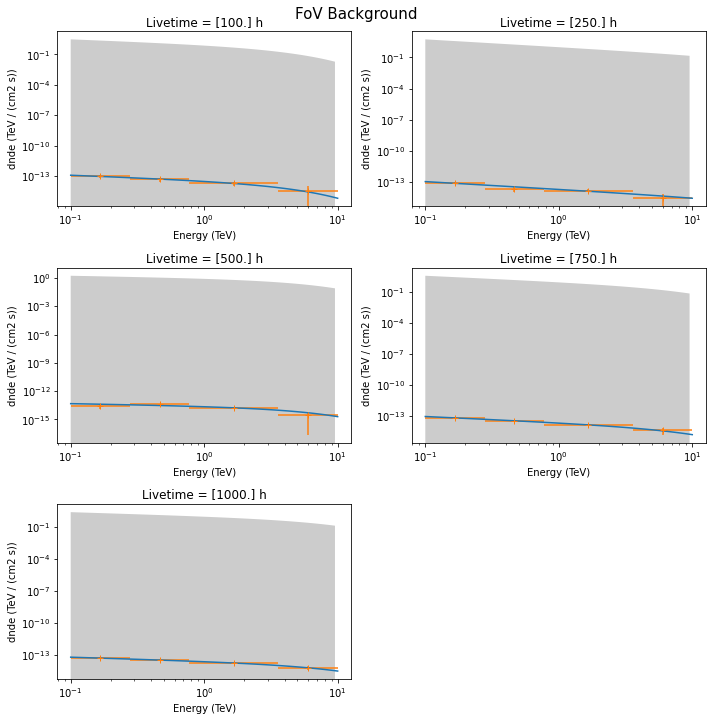

In [20]:
fig = plt.figure(figsize = [10,10], tight_layout=True)
fig.suptitle('FoV Background', verticalalignment = 'baseline', fontsize = 15)
plt.subplot(321)
flux_plt(model_[0],dataset_[0])
plt.subplot(322)
flux_plt(model_[1],dataset_[1])
plt.subplot(323)
flux_plt(model_[2],dataset_[2])
plt.subplot(324)
flux_plt(model_[3],dataset_[3])
plt.subplot(325)
flux_plt(model_[4],dataset_[4])

In [21]:
print(model_[0].spectral_model.parameters.to_table())
print(model_[1].spectral_model.parameters.to_table())
print(model_[2].spectral_model.parameters.to_table())
print(model_[3].spectral_model.parameters.to_table())
print(model_[4].spectral_model.parameters.to_table())

   name     value         unit      min max frozen   error  
--------- ---------- -------------- --- --- ------ ---------
    index 2.5023e+00                nan nan  False       nan
amplitude 3.8328e-14 cm-2 s-1 TeV-1 nan nan  False       nan
reference 1.0000e+00            TeV nan nan   True 0.000e+00
  lambda_ 2.9513e-01          TeV-1 nan nan  False       nan
    alpha 1.0000e+00                nan nan   True 0.000e+00
   name     value         unit      min max frozen   error  
--------- ---------- -------------- --- --- ------ ---------
    index 2.7465e+00                nan nan  False       nan
amplitude 1.9975e-14 cm-2 s-1 TeV-1 nan nan  False       nan
reference 1.0000e+00            TeV nan nan   True 0.000e+00
  lambda_ 2.5657e-02          TeV-1 nan nan  False       nan
    alpha 1.0000e+00                nan nan   True 0.000e+00
   name     value         unit      min max frozen   error  
--------- ---------- -------------- --- --- ------ ---------
    index 2.2494e+00    

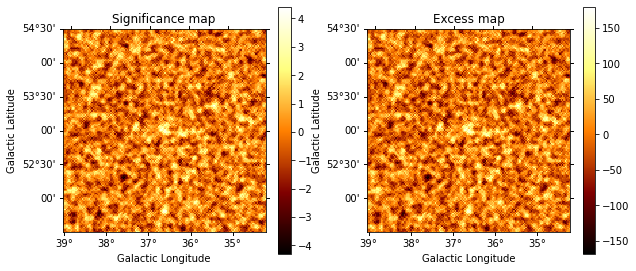

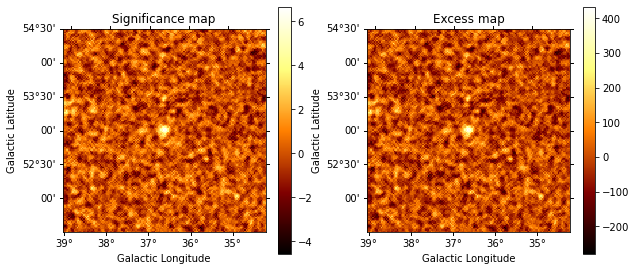

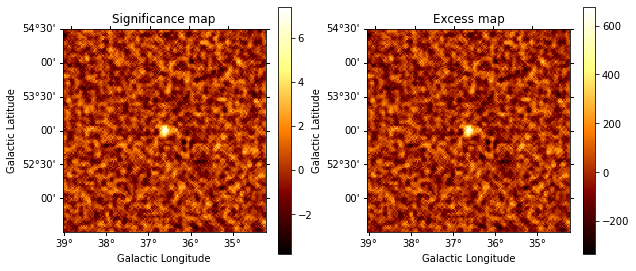

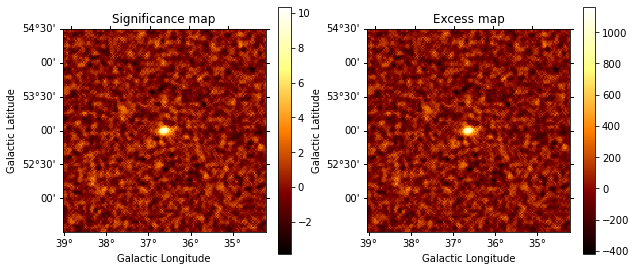

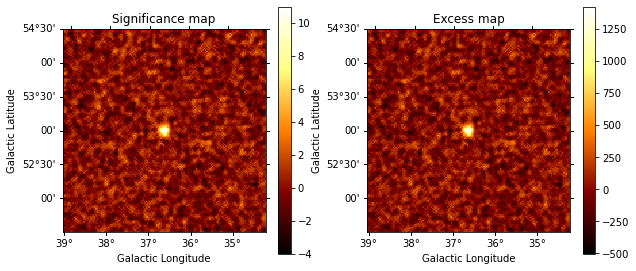

In [22]:
excess_maps(significance_[0], excess_[0])
excess_maps(significance_[1], excess_[1])
excess_maps(significance_[2], excess_[2])
excess_maps(significance_[3], excess_[3])
excess_maps(significance_[4], excess_[4])

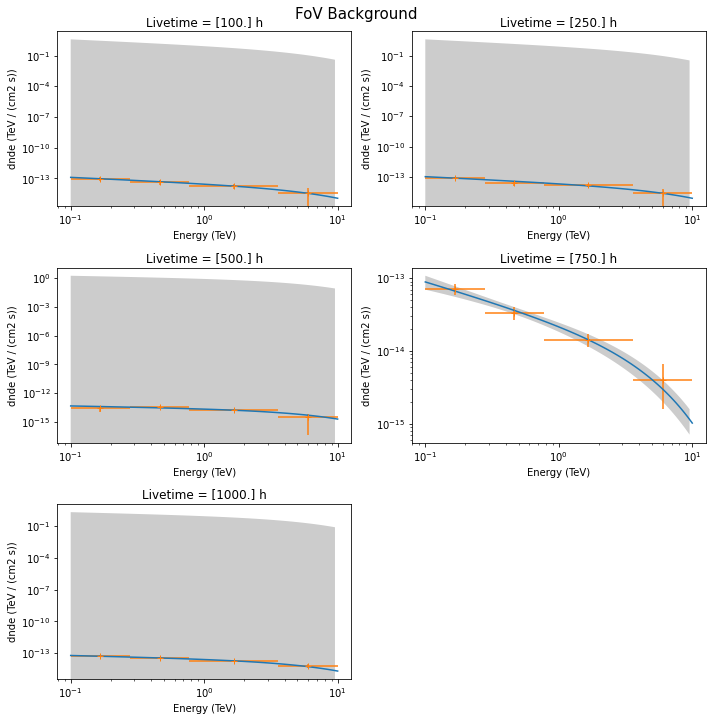

In [23]:
fig = plt.figure(figsize = [10,10], tight_layout=True)
fig.suptitle('FoV Background', verticalalignment = 'baseline', fontsize = 15)
plt.subplot(321)
flux_plt(model_1[0],dataset_1[0])
plt.subplot(322)
flux_plt(model_1[1],dataset_1[1])
plt.subplot(323)
flux_plt(model_1[2],dataset_1[2])
plt.subplot(324)
flux_plt(model_1[3],dataset_1[3])
plt.subplot(325)
flux_plt(model_1[4],dataset_1[4])

In [24]:
print(model_1[0].spectral_model.parameters.to_table())
print(model_1[1].spectral_model.parameters.to_table())
print(model_1[2].spectral_model.parameters.to_table())
print(model_1[3].spectral_model.parameters.to_table())
print(model_1[4].spectral_model.parameters.to_table())

   name     value         unit      min max frozen   error  
--------- ---------- -------------- --- --- ------ ---------
    index 2.5902e+00                nan nan  False       nan
amplitude 3.3543e-14 cm-2 s-1 TeV-1 nan nan  False       nan
reference 1.0000e+00            TeV nan nan   True 0.000e+00
  lambda_ 2.0000e-01          TeV-1 nan nan   True 0.000e+00
    alpha 1.0000e+00                nan nan   True 0.000e+00
   name     value         unit      min max frozen   error  
--------- ---------- -------------- --- --- ------ ---------
    index 2.6402e+00                nan nan  False       nan
amplitude 2.4682e-14 cm-2 s-1 TeV-1 nan nan  False       nan
reference 1.0000e+00            TeV nan nan   True 0.000e+00
  lambda_ 2.0000e-01          TeV-1 nan nan   True 0.000e+00
    alpha 1.0000e+00                nan nan   True 0.000e+00
   name     value         unit      min max frozen   error  
--------- ---------- -------------- --- --- ------ ---------
    index 2.2545e+00    

/home/rishank/anaconda2/envs/gammapy-0.18.2/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: The handle <matplotlib.collections.PolyCollection object at 0x7fbab1002a90> has a label of '_nolegend_' which cannot be automatically added to the legend.
  """
/home/rishank/anaconda2/envs/gammapy-0.18.2/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: The handle <matplotlib.collections.PolyCollection object at 0x7fba88371748> has a label of '_nolegend_' which cannot be automatically added to the legend.
  """
/home/rishank/anaconda2/envs/gammapy-0.18.2/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: The handle <matplotlib.collections.PolyCollection object at 0x7fba885d5320> has a label of '_nolegend_' which cannot be automatically added to the legend.
  if __name__ == '__main__':
/home/rishank/anaconda2/envs/gammapy-0.18.2/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: The handle <matplotlib.collections.PolyCollection obje

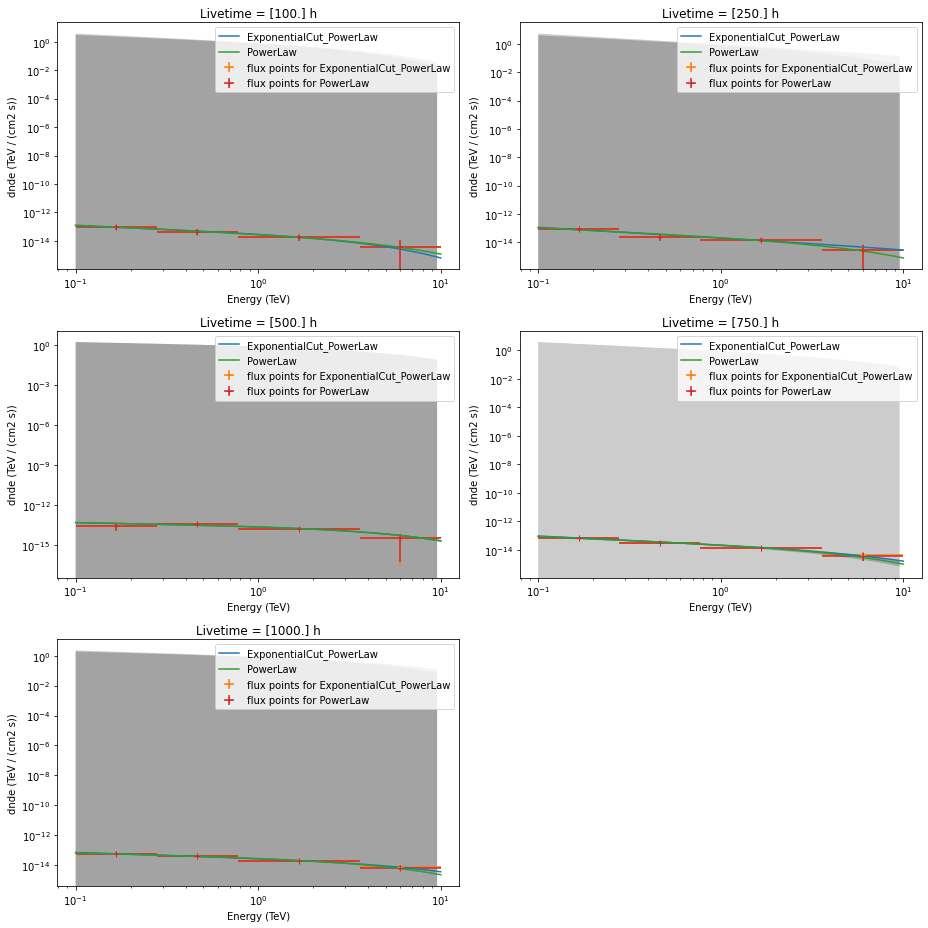

In [25]:
fig = plt.figure(figsize = [13,13], tight_layout=True)
plt.subplot(321)
flux_plt(model_[0],dataset_[0])
flux_plt(model_1[0],dataset_1[0])
plt.legend(['ExponentialCut_PowerLaw','PowerLaw','_nolegend_','_nolegend_','flux points for ExponentialCut_PowerLaw','flux points for PowerLaw'])
plt.subplot(322)
flux_plt(model_[1],dataset_[1])
flux_plt(model_1[1],dataset_1[1])
plt.legend(['ExponentialCut_PowerLaw','PowerLaw','_nolegend_','_nolegend_','flux points for ExponentialCut_PowerLaw','flux points for PowerLaw'])
plt.subplot(323)
flux_plt(model_[2],dataset_[2])
flux_plt(model_1[2],dataset_1[2])
plt.legend(['ExponentialCut_PowerLaw','PowerLaw','_nolegend_','_nolegend_','flux points for ExponentialCut_PowerLaw','flux points for PowerLaw'])
plt.subplot(324)
flux_plt(model_[3],dataset_[3])
flux_plt(model_1[3],dataset_1[3])
plt.legend(['ExponentialCut_PowerLaw','PowerLaw','_nolegend_','_nolegend_','flux points for ExponentialCut_PowerLaw','flux points for PowerLaw'])
plt.subplot(325)
flux_plt(model_[4],dataset_[4])
flux_plt(model_1[4],dataset_1[4])
plt.legend(['ExponentialCut_PowerLaw','PowerLaw','_nolegend_','_nolegend_','flux points for ExponentialCut_PowerLaw','flux points for PowerLaw'])

In [26]:
def flux_plt_1(model, dataset, simu):
    spec = model.spectral_model
    energy_edges = np.logspace(-1.0, 1.0, 5) * u.TeV
    fpe = FluxPointsEstimator(energy_edges=energy_edges)
    flux_points = fpe.run(datasets=[dataset])
    energy_range = [0.1, 10] * u.TeV
    simu.spectral_model.plot(energy_range=energy_range, energy_power=2)
    spec.plot(energy_range=energy_range, energy_power=2)
    ax = spec.plot_error(energy_range=energy_range, energy_power=2)
    flux_points.plot(ax=ax, energy_power=2)
    plt.title("Livetime = "+str(dataset.gti.time_delta.to(u.hr)))#, fontsize='15')
    plt.legend(['input model','best fit'])
    return

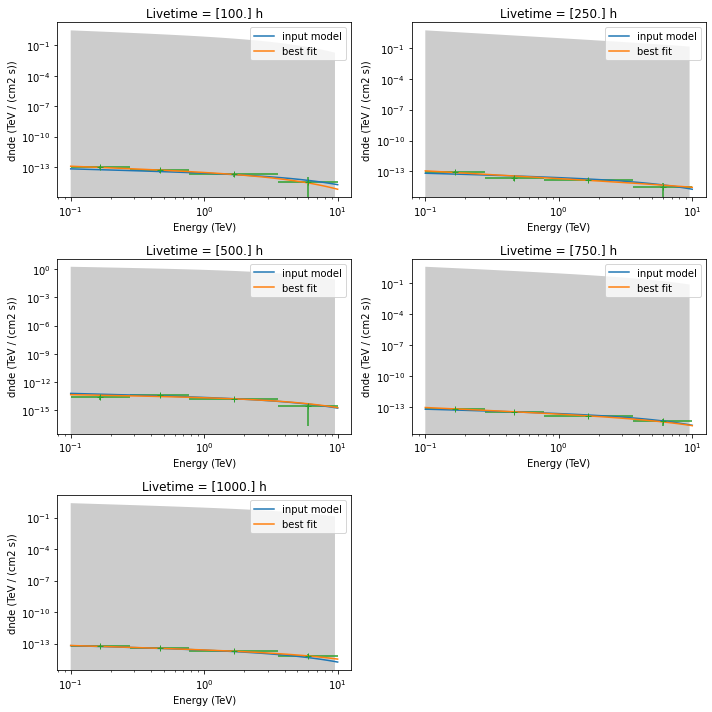

In [27]:
fig = plt.figure(figsize = [10,10], tight_layout=True)
#fig.suptitle('FoV Background', verticalalignment = 'baseline', fontsize = 15)
plt.subplot(321)
flux_plt_1(model_[0],dataset_[0], model_simu)
plt.subplot(322)
flux_plt_1(model_[1],dataset_[1], model_simu)
plt.subplot(323)
flux_plt_1(model_[2],dataset_[2], model_simu)
plt.subplot(324)
flux_plt_1(model_[3],dataset_[3], model_simu)
plt.subplot(325)
flux_plt_1(model_[4],dataset_[4], model_simu)

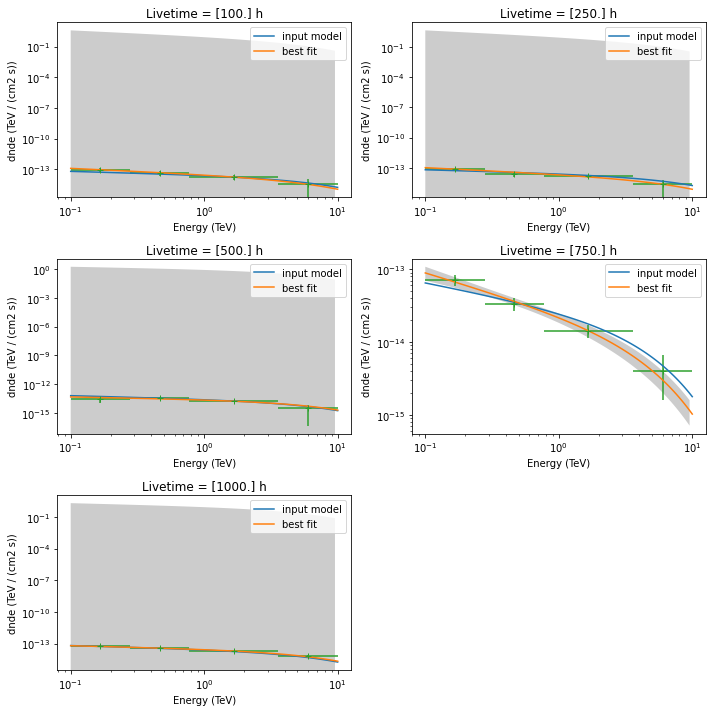

In [28]:
fig = plt.figure(figsize = [10,10], tight_layout=True)
#fig.suptitle('FoV Background', verticalalignment = 'baseline', fontsize = 15)
plt.subplot(321)
flux_plt_1(model_1[0],dataset_1[0], model_simu)
plt.subplot(322)
flux_plt_1(model_1[1],dataset_1[1], model_simu)
plt.subplot(323)
flux_plt_1(model_1[2],dataset_1[2], model_simu)
plt.subplot(324)
flux_plt_1(model_1[3],dataset_1[3], model_simu)
plt.subplot(325)
flux_plt_1(model_1[4],dataset_1[4], model_simu)